- **오토인코더**는 어떤 지도 없이도(즉, 레이블되어 있지 않은 훈련 데이터를 사용해서) **잠재 표현** 또는 **코딩**이라고 불는 입력 데이터의 밀집 표현을 학습할 수 있는 인공 신경망입니다.

# 2. 과소완전 선형 오토인코더로 PCA 수행하기
- **과소완전** : 내부의 표현이 입력 데이터보다 저차원이기때문에(즉, 3차원 대신 2차원) 이런 토인코더

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [5]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

- 3D 데이터셋에 PCA를 적용해 2D에 투영하는 간단한 선형 오토인코더를 만듬

In [6]:
# 데이터셋 생성

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [19]:
from tensorflow import keras

# np.random.seed(42)
# tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

- 오토인코더를 이니코더와 디코더 두 개 컴포넌트로 구성. 
- 오토인코더의 출력 개수가 입력의 개수와 동일(즉 3개)
- 단순환 PCA를 수행하기 위해서는 활성화 함수를 사용하지 않으며(즉 모든 뉴런이 선형), 비용 함수는 MSE 

In [20]:
# 위 모델을 가상으로 생성한 간단한 3D 데이터셋에 훈련

history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 995us/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 

Saving figure linear_autoencoder_pca_plot


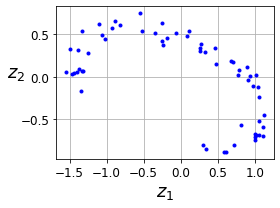

In [21]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

- 오토인코더는 (PCA처럼) 데이터에 있는 분산이 가능한 많이 보존되도록 데이터를 투영할 최상의 2D평면을 찾는다.

# 3. 적층 오토 인코더
- 은닉층을 여러개 가지는 것
- 구조는 전형적으로 가운데 은닉층(코딩 층)을 기준으로 대칭

## 3.1 케라스를 사용하여 적층 오토인코더 구현
- 10장 패션 mnist 데이터셋에서 SELU활성화 함수를 사용해 적층  오토인코더 만듬

In [13]:
# 패션 mnist 훈련셋과 검증셋으로 분리

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [14]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

# 인코더
# 28 X 28 픽셀의 흑백 이미지를 받아 각 이미지를 784 크기의 벡터로 표현하기 위해 펼침 
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"), # 크기가 30인 벡터를 출력
])

# 디코더
# 크기가 30인 벡터를 받음. 
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"), 
    keras.layers.Reshape([28, 28]) # 최종 벡터를 28 x 28 배열로 변경하여 디코더의 출력이 인코더의 입력과 동일한 크기가 되도록 함
])

# 오토인코더
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder]) 

# 모델 컴파일
# 다중 레이블 이중분류 문제로 다루는 것
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
# X_train을 입려과 타깃으로 사용해 모델을 훈련
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9003
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9197
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2983 - val_rounded_accuracy: 0.9205
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

## 3.2 재구성 시각화
- 오토인코더가 적절히 훈련되었는지 확인하는 한 가지 방법은 입력과 출력을 비교해 보는 것
- 즉, 입력과 출력의 차이가 너무 크지 않아야 함

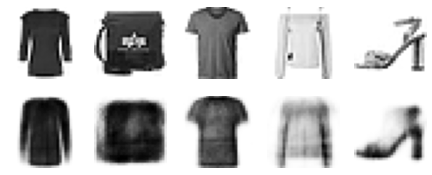

In [17]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    
    for image_index in range(n_images):
        # 원복 이미지
        plt.subplot(2, n_images, 1+image_index)
        plot_image(X_valid[image_index])
        
        # 재구성 이미지
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)

- 재구성된 이미지를 식별할 수는 있지만 정보를 조금 많이 잃어 버림. 모델ㅇ르 더 오래 훈련하거나 인코더와 디코더의 층을 느리거나 코딩의 크기를 늘려야 할지도 모름, 하지만 데이터에서 어떤 유익한 패턴을 학습하지 모사고 완벽한 재구성 이미지를 만들 것이다.


## 3.3 패션 MNIST 데이터셋 시각화
- 오토인코더의 장점은 샘플과 특성이 많은 대용량 데이터셋을 다를 수 있다는 점
- 따라서 오통ㄴ코더를 사용해 적절한 수준으로 차원을 축소한 후 다른 차원 축소 알고리즘을 사용해 시각화하는 것도 전략.
- 이 방식으로 패션 MNIST 데이터셋을 시각화 해보자

In [31]:
# 오토인코더의 인코더 모델을 사용해 차원을 30으로 줄이고 t-SNE알고리즘을 구현한 사이킷런 클리스로 시각화를 위해 차원을 2까지 줄임

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

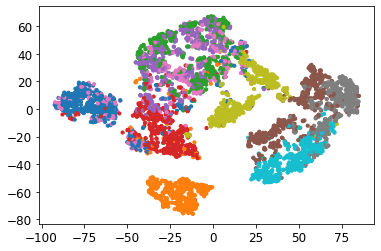

In [32]:
# 데이터셋을 그래프로 그림

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:,1], c=y_valid, s=10, cmap='tab10')

Saving figure fashion_mnist_visualization_plot


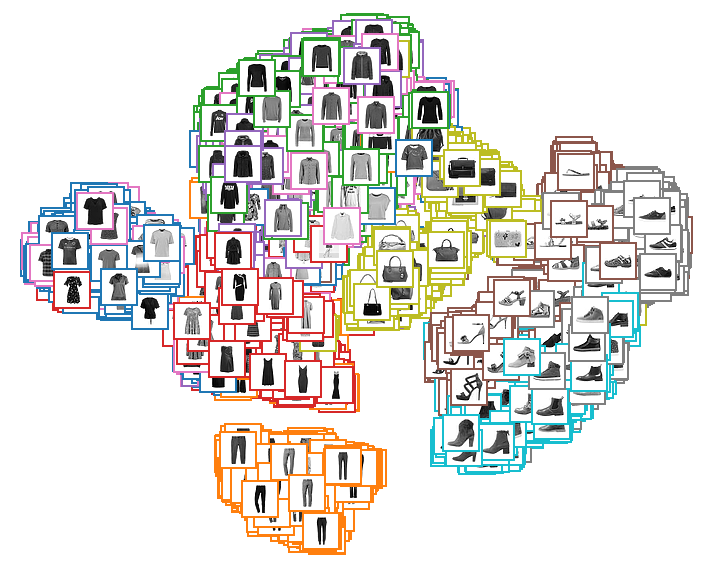

In [34]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

---
오토인코더를 훈련하기 위한 몇 가지 기술

## 3.5 가중치 묶기
- 오토인코더가 완벽하게 대칭일 땐 디코더의 가중치와 인코더의 가중치를 묶는 것이 일반적인 방법
- 이렇게 하면 모델에 있는 가중치의 수를 절반으로 줄여서 훈련 속도를 높이고 과대적합의 위험을 줄여줌

In [38]:
# 케라스의 사용자 정의 층을 만들어 층 간에 가중치를 묶어본다.

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3080 - val_rounded_accuracy: 0.9080
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2952 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3019 - val_rounded_accuracy: 0.9083
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2875 - val_rounded_accuracy: 0.9312
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

이 모델은 거의 절반의 파라미터로 이전 모델보다 약간 낮은 재구성 오차를 달성함

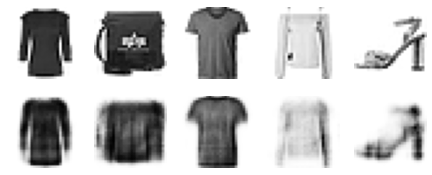

In [40]:
show_reconstructions(tied_ae)
plt.show()

# 4. 합성곱 오토인코더
- 이미지를 다루는 경우에는 (이미지가 매우 작지 않다면) 오토인코더가 좋은 성능을 내지 못함
- 이미지를 다룰 때는 합성곱 신경망이 밀집 네트워크보다 훨씬 잘 맞는다.
- 인코더는 합성곱 층과 풀링 층으로 구성된 일반적인 CNN
- 인코더는 전형적으로 입력에서 공간 방향이 차원(즉, 높이와 너비)을 줄이고 깊이(즉, 특성 맵의 개수)를 늘린다.
- 디코더는 거꾸로 동작해야 함(이미지 스케일을 늘리고 깊이를 원본 차원으로 되돌려야 한다.)
- 이를 위해서 전치 합성곱 층을 사용(또는 합성곱 층과 업 샘플링 층을 연결할 수 있음)

In [43]:
# MNIST 데이터셋에 대한 간단한 합성곱 오토인코더

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])


conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [44]:
# 모델 컴파일
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 24s 13ms/step - loss: 0.3019 - rounded_accuracy: 0.9187 - val_loss: 0.2842 - val_rounded_accuracy: 0.9300
Epoch 2/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2697 - val_rounded_accuracy: 0.9495
Epoch 4/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2686 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2671 - val_rounded_accuracy: 0.9509


In [45]:
# 인코더, 디코더 서머리 확인

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)         

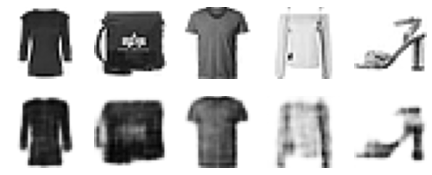

In [46]:
show_reconstructions(conv_ae)
plt.show()

# 5. 순환 오토인코더
- (비지도 학습이나 차운축소를 위해) 시계열이나 텍스트와 같은 시쿼스에 대한 오토인코더를 만드려면 순환 신경망이 밀집 네트워크보다 더 나을 수 있음. 
- 인코더는 일반적으로 입력 시퀀스를 하나의 벡터로 압축하는 시퀀스-투-벡터 RNN이다.
- 디코더는 반대로 벡터-투-시퀀스 RNN이다.

In [47]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 50s 27ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 57s 33ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3742 - val_rounded_accuracy: 0.8685
Epoch 3/10
1719/1719 [==============================] - 64s 37ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3602 - val_rounded_accuracy: 0.8769
Epoch 4/10
1719/1719 [==============================] - 66s 39ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3526 - val_rounded_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 77s 45ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3360 - val_rounded_accuracy: 0.8923
Epoch 6/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3308 - val_rounded_accuracy: 0.8967
Epoch 7/10
1719/1719 [======

타임 스텝마다 입력 벡터를 주입하기 우해 디코더이 첫 번째 층에 RepeatVector 층을 사용한 점에 주목!!

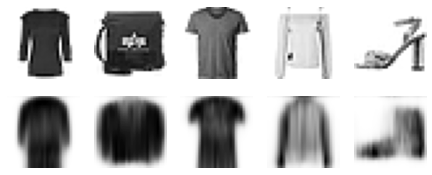

In [48]:
show_reconstructions(recurrent_ae)
plt.show()

---
과대완전 오토인코더

# 6. 잡음 제거 오토인코더
- 오코인코더가 이융한 특성을 학습하도록 강제하는 다른 방법은 입력에 잡음을 추가하고, 잠을이 없는 원본 입력을 복원하도록 훈련하는 것
- 잡음은 입력에 추가된 순수한 가우시안 잡음이거나 드롭아웃처럼 무작위 입역을 꺼서 발생시킬 수 있음
- Dropout 층은 훈련하는 동안에만 활성화됨
-

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [20]:
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

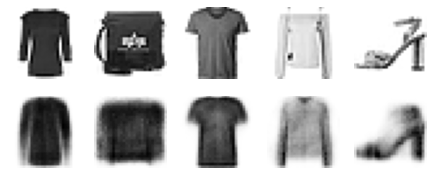

In [24]:
# 이미지 확인

tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

# 희소 오토인코더
- 좋은 특성을 추출하도록 만드는 다른 제약의 방식은 **희소**이다
- 이는 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런 수를 감소시키도록 만든다.

In [34]:
tf.random.set_seed(42)
np.random.seed(42)
 
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  #  # 입력을 그래로 반환하면서 훈현 손실에 입력의 절댓값의 합을 더함

])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

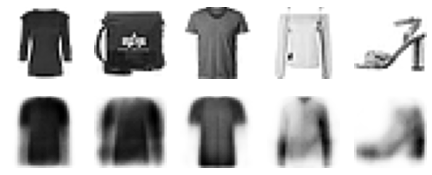

In [35]:
show_reconstructions(sparse_l1_ae)
plt.show()

In [36]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [37]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

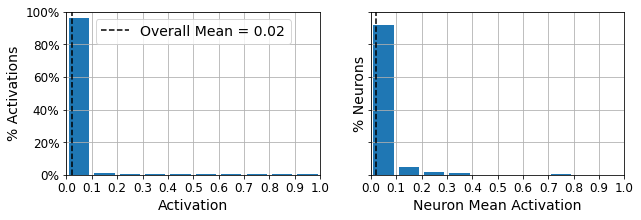

In [38]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Saving figure sparsity_loss_plot


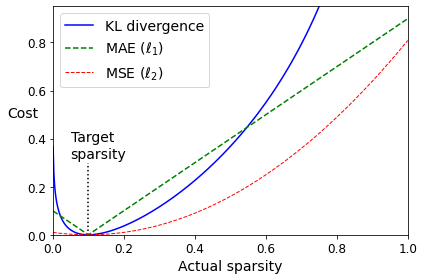

In [39]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [41]:
# KL 발산 구제를 적용하기 위해 사용자 정의 규제

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) +kl_divergence(1. - self.target, 1. - mean_activities))

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

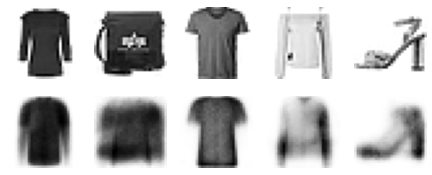

In [43]:
show_reconstructions(sparse_kl_ae)

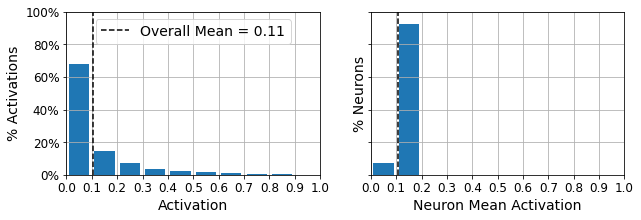

In [44]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

# 희소 오토인코더를 훈련한 후 코딩 층에 있는 뉴런 의 활성화가 거의 0에 가깝게 됨
# 

# 8. 변이형 오토인코더
- 확률적 오토인코더이다. 즉, 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨.(이와는 반대로 잡음 제거 오토인코더는 훈련 시에만 무작위성을 사용)
- 무엇보다도 생성인코더라는 점이 중요!!! 마치 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성할 수 있음.

In [45]:
# 코딩을 샘플링하는 사용자 정의 층

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [49]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


# 디코더
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])


In [50]:
# 변이형 모델

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3895 - rounded_accuracy: 0.8613 - val_loss: 0.3629 - val_rounded_accuracy: 0.8890
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3436 - rounded_accuracy: 0.8973 - val_loss: 0.3396 - val_rounded_accuracy: 0.9010
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3329 - rounded_accuracy: 0.9051 - val_loss: 0.3368 - val_rounded_accuracy: 0.8988
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3276 - rounded_accuracy: 0.9095 - val_loss: 0.3241 - val_rounded_accuracy: 0.9153
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3242 - rounded_accuracy: 0.9122 - val_loss: 0.3295 - val_rounded_accuracy: 0.9027
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3220 - rounded_accuracy: 0.9139 - val_loss: 0.3240 - val_rounded_accuracy: 0.9147
Epoch 7/25
430/430 [==============================] 

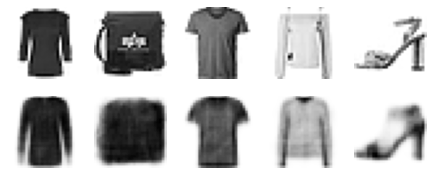

In [51]:
show_reconstructions(variational_ae)
plt.show()

## 8.1 패션 MNIST 이미지 생성하기
- 이 변이형 오토인코더를 사용해 패션 의류 =처럼 보이는 이미지를 생성해보겠음

In [52]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Saving figure vae_generated_images_plot


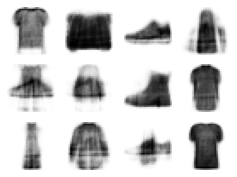

In [53]:
# 이미지 생성과 확인

tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Saving figure semantic_interpolation_plot


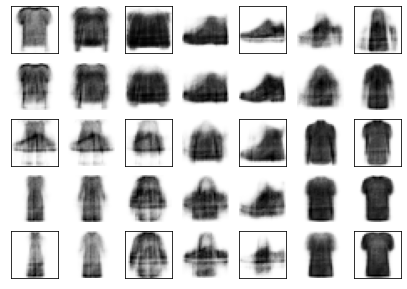

In [54]:
#  변이형 오토인코더는 시맨틱 보간을 수행할 수 있음(두 이미지가 겹쳐 보이는 것 같은)

tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# 원본 이미지 테두리 표시, 나머지는 근방의 이미지를 시맨틱 보간한 결과이다ㅏ.

- 지난 몇 년간 변이형 오토인코더가 널리 사용됨. 하지만 GAN이 훨씬 실제같이 또렷한 이밎를 만들 수 있어서 인기가 높아짐

# 9. 생성적  적대 신경망
- 첫 번째 단계 
        판별자를 훈련함. 훈련 세트에서 실제 이미지 배치를 샘플링하고 생성자에게 생성한 동일한 수의 가짜 이미지를 합친다.
        가짜 이미지의 레이블은 0으로 세팅하고 진짜 이미지는 1로 세팅한다. 
- 두 번째 단계 : 
        생성자 훈련함. 먼저 생성자를 사용해 다른 가자 이밎 배치를 만듬. 다시 판별자를 사용해 이미지가 진짜인지 가짜인지를 판별

In [55]:
codings_size = 30

# 생성자
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# 판별자
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

# 모델 컴파일
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") # 판별자는 이진분류이기에 binary_crossentropy 사용
discriminator.trainable = False

# 생성자는 gan 모델을 통해서만 훈련되기 때문에 따로 컴파일 할 필요 없음
gan.compile(loss="binary_crossentropy", optimizer = "rmsprop")

- 훈련이 일반적인 반복이 아니기 때문에 fit() 메서드를 사용할 수 없음
- 대신 사용자 정의 훈련 반복문을 만듬. 이를 위해 먼저 이미지를 순회하는 Dataset을 만듬

In [56]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [57]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()    

Epoch 1/1


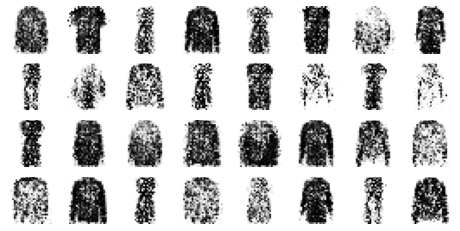

In [58]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

- 위 이미지 보다 더 좋은 이미지는 생성되지 않음. GAN 훈련이 어렵다고 말하는 이유

## 9.2 Deep Convolutional GAN (심층 합성곱 GAN)
- (판별자에 있는) 풀링 층을 스트라이드 합성곱으로 바꾸고 (생성자가 있는0 풀링 층은 전치  합성곱으로 바꿈
- 생성자와 판별자에 배치 정규화를 사용. 생성자의 출력층과 판별자의 입력층은 제외!
- 층을 깊게 쌓기 위해 완전 연결 은닉층을 제거한다.
- tanh 함수를 사용해야 하는 출력층은 제외하고 생성자의 모든 층은 ReLU 활성화 함수를 사용한다.
- 판별자의 모든 층은 LeakyReLU 활성화 함수를 사용한다.

In [59]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape = [codings_size]), 
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [60]:
# 모델 컴파일

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [61]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # 크기 변경과 스케일 조정

Epoch 1/50


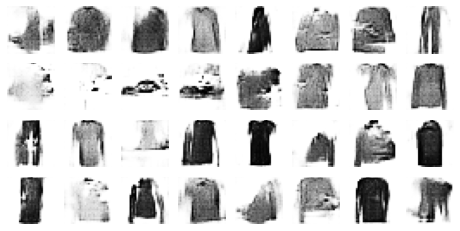

Epoch 2/50


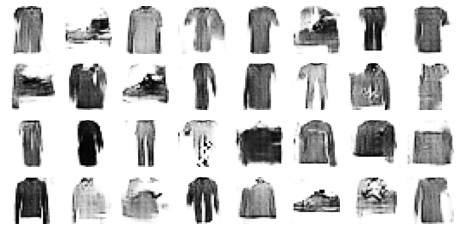

Epoch 3/50


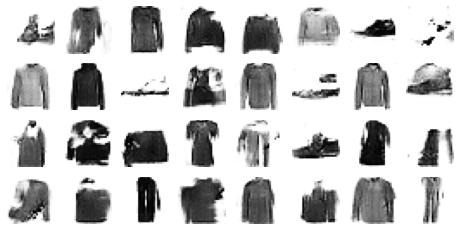

Epoch 4/50


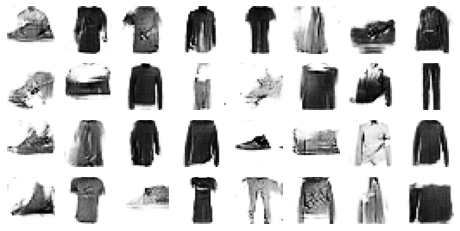

Epoch 5/50


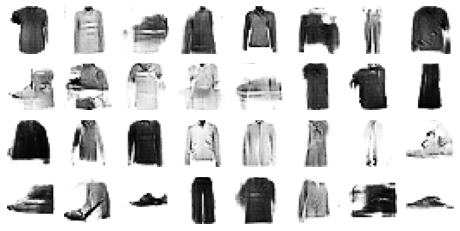

Epoch 6/50


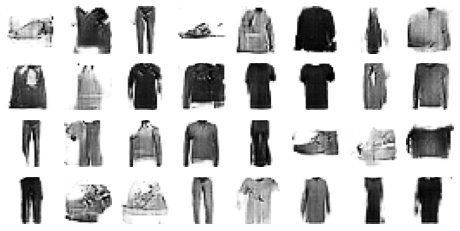

Epoch 7/50


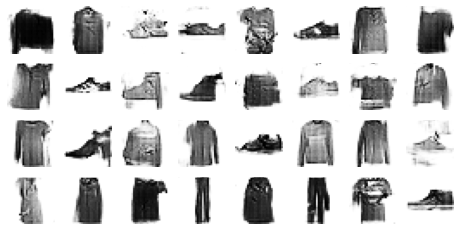

Epoch 8/50


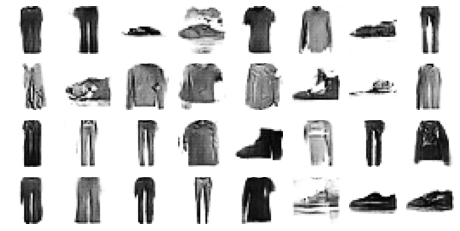

Epoch 9/50


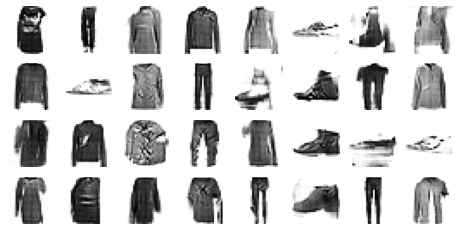

Epoch 10/50


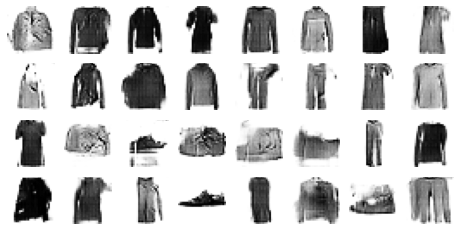

Epoch 11/50


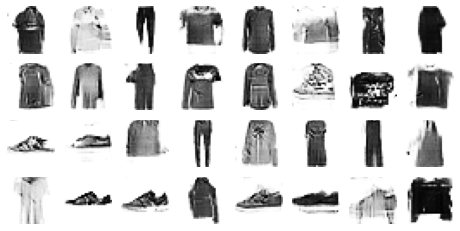

Epoch 12/50


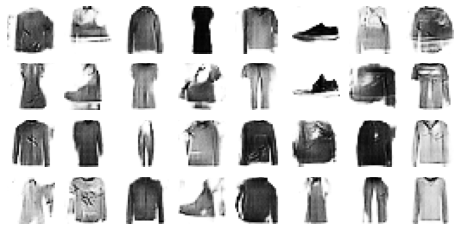

Epoch 13/50


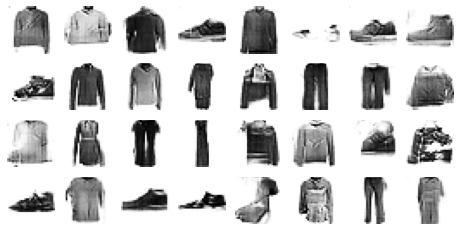

Epoch 14/50


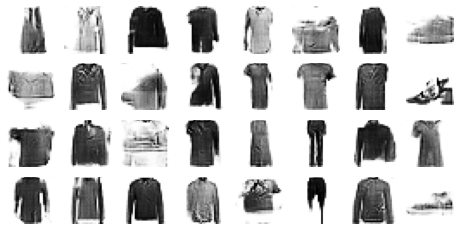

Epoch 15/50


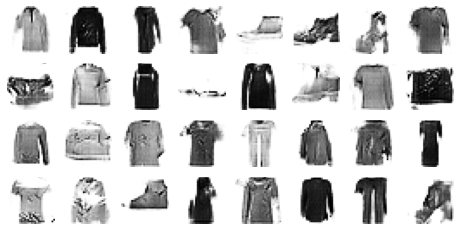

Epoch 16/50


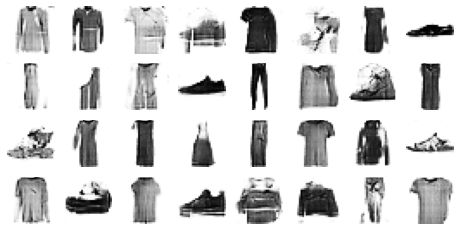

Epoch 17/50


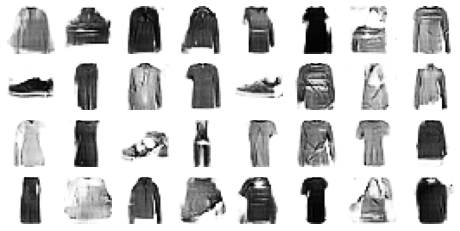

Epoch 18/50


In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)